In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data

- Load train, test and val data

- define functions for generating time_step data

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
val_data = pd.read_csv('data/val.csv')

In [3]:
train_data

,L1,H1,L2,H2,train_loss_epoch1,eval_loss_epoch1,eval_acc_epoch1,train_loss_epoch2,eval_loss_epoch2,eval_acc_epoch2,...,eval_acc_epoch147,train_loss_epoch148,eval_loss_epoch148,eval_acc_epoch148,train_loss_epoch149,eval_loss_epoch149,eval_acc_epoch149,train_loss_epoch150,eval_loss_epoch150,eval_acc_epoch150
0,0.3,0.6,0.0,0.0,1.79684,1.51030,0.4502,1.78262,1.35697,0.5097,...,0.6908,1.30036,0.96875,0.6875,1.29888,0.98039,0.6884,1.29986,0.97649,0.6903
1,0.3,0.8,0.0,0.0,1.73990,1.42823,0.4891,1.72468,1.25468,0.5453,...,0.7269,1.21714,0.87241,0.7275,1.21584,0.88057,0.7269,1.21472,0.87955,0.7289
2,0.3,1.0,0.0,0.0,1.76364,1.44369,0.4752,1.74716,1.29603,0.5323,...,0.7287,1.23160,0.87199,0.7289,1.23162,0.87129,0.7316,1.23094,0.85087,0.7308
3,0.3,1.2,0.0,0.0,1.74520,1.41304,0.4939,1.73030,1.27203,0.5508,...,0.7333,1.22378,0.86177,0.7344,1.22378,0.85618,0.7283,1.22098,0.84891,0.7331
4,0.3,1.4,0.0,0.0,1.72272,1.39383,0.4962,1.70696,1.22993,0.5540,...,0.7448,1.18340,0.80875,0.7469,1.18148,0.80955,0.7482,1.17894,0.80346,0.7458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.3,0.4,0.5,0.4,1.86408,1.82807,0.3719,1.85192,1.63184,0.4287,...,0.5362,1.47340,1.44026,0.5541,1.47250,1.39093,0.5316,1.47304,1.40396,0.5526
95,0.3,0.4,0.5,0.8,1.86876,1.73903,0.3787,1.85634,1.62275,0.4295,...,0.5712,1.47028,1.35739,0.5737,1.46950,1.34127,0.5694,1.46914,1.33777,0.5735
96,0.3,0.4,0.5,1.2,1.85084,1.68773,0.4061,1.83724,1.63667,0.4327,...,0.5701,1.43926,1.40934,0.5729,1.43866,1.38772,0.5781,1.43670,1.39692,0.5715
97,0.3,0.4,0.8,0.4,1.86096,1.67760,0.3877,1.85040,1.57096,0.4251,...,0.5530,1.48610,1.40470,0.5585,1.48482,1.41873,0.5589,1.48320,1.44541,0.5531


In [112]:
def get_np_data(data, time_steps):
    np_data = []
    hp = data.iloc[:,:4]
    for i in range(len(hp)):
        kk = []
        for j in range(time_steps):
            dd = []
            dd += list(hp.iloc[i])
            dd.append(data.iloc[i]["train_loss_epoch"+str(j+1)])
            dd.append(data.iloc[i]["eval_loss_epoch"+str(j+1)])
            dd.append(data.iloc[i]["eval_acc_epoch"+str(j+1)])
            kk.append(dd)
        np_data.append(kk)
    return np.array(np_data)

def get_np_y_data(data):
    return np.array(list(data["eval_acc_epoch150"])).reshape(-1,1)

# Modelling Strategy

- Time series data

- LSTM that reads first N epoch information and predicts 150th epoch accuracy

- Input attributes:
    - hyperparameter vector
    - train_loss till epoch E
    - eval_loss till epoch E
    - eval_acc till epoch E

- Output prediction
    - eval acc on epoch 150-E

### E=5, M=150

In [114]:
# define parameters
num_sequences = 10
time_steps = 5
features = 7
batch_Size = 8

# Get data
train_np_data_x = get_np_data(train_data, time_steps)
val_np_data_x = get_np_data(val_data, time_steps)
test_np_data_x = get_np_data(test_data, time_steps)
train_np_data_y = get_np_y_data(train_data)
val_np_data_y = get_np_y_data(val_data)
test_np_data_y = get_np_y_data(test_data)

# define model
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 16)             1536      
                                                                 
 lstm_23 (LSTM)              (None, 32)                6272      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.compile(optimizer='adam', loss='mse')

In [106]:
checkpoint = ModelCheckpoint(
    filepath='./ckpt/e5/model_epoch_{epoch:02d}.h5',  # Path to save the model file with epoch number
    monitor='val_loss',  
    save_best_only=False,  
    mode='auto',  
    verbose=1,
    save_freq='epoch'
)

In [107]:
history = model.fit(train_np_data_x, train_np_data_y, epochs=50, batch_size=batch_Size, validation_data=(val_np_data_x, val_np_data_y) ,callbacks=[checkpoint])

Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: 1.1632
Epoch 1: saving model to ./ckpt/e5/model_epoch_01.h5
13/13 [==============================] - 5s 65ms/step - loss: 1.1361 - val_loss: 0.5792
Epoch 2/50
11/13 [========================>.....] - ETA: 0s - loss: 0.2661
Epoch 2: saving model to ./ckpt/e5/model_epoch_02.h5
13/13 [==============================] - 0s 24ms/step - loss: 0.2502 - val_loss: 0.1314
Epoch 3/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1027
Epoch 3: saving model to ./ckpt/e5/model_epoch_03.h5
13/13 [==============================] - 0s 30ms/step - loss: 0.1005 - val_loss: 0.0492
Epoch 4/50
11/13 [========================>.....] - ETA: 0s - loss: 0.0321
Epoch 4: saving model to ./ckpt/e5/model_epoch_04.h5
13/13 [==============================] - 0s 24ms/step - loss: 0.0317 - val_loss: 0.0131
Epoch 5/50
13/13 [==============================] - ETA: 0s - loss: 0.0176
Epoch 5: saving model to ./ckpt/e5/model_epoch_05.h5
13/13 [=

In [109]:
prediction = model.predict(test_np_data_x)

2/2 [==============================] - 0s 5ms/step


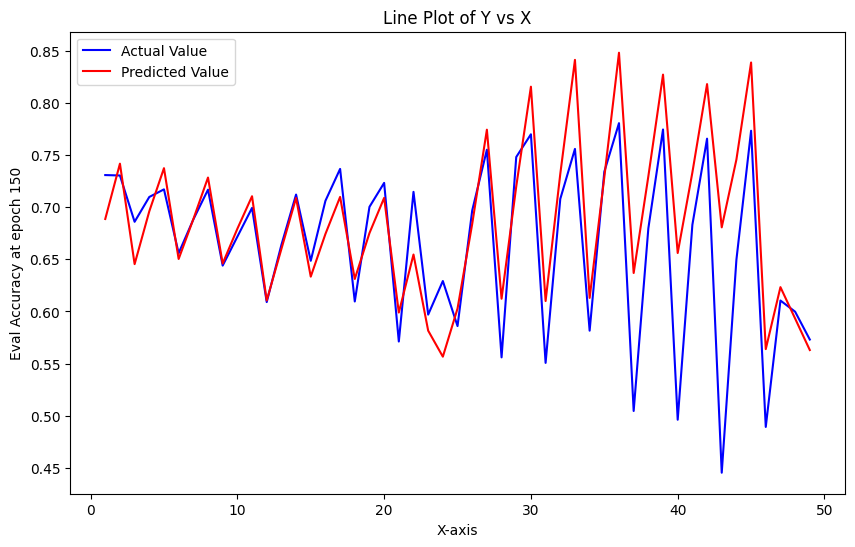

In [110]:
x = [i+1 for i in range(len(test_np_data_x))]
y1 = test_np_data_y
y2 = prediction

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Actual Value', color='blue')
plt.plot(x, y2, label='Predicted Value', color='red')
plt.title('Line Plot of Y vs X')
plt.xlabel('X-axis')
plt.ylabel('Eval Accuracy at epoch 150')
plt.legend()
plt.show()

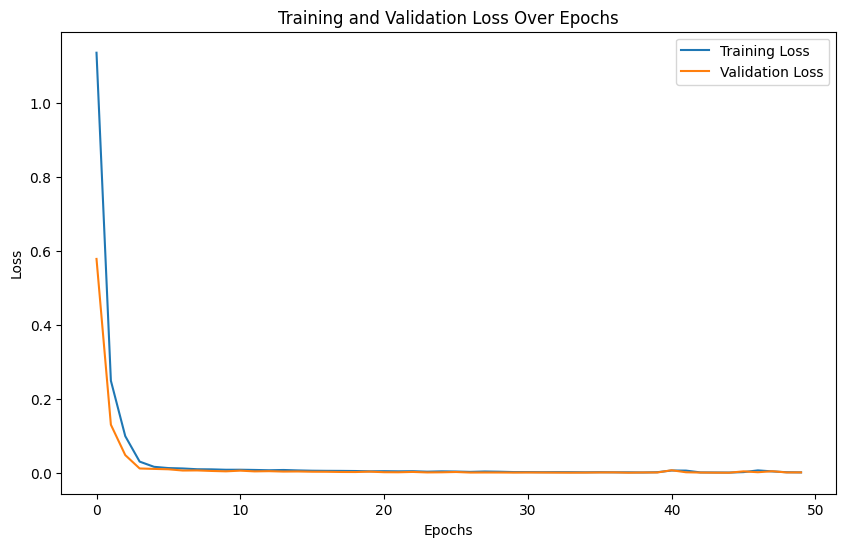

In [111]:
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Showing the plot
plt.show()

### E=10, M=150

In [191]:
# define parameters
num_sequences = 10
time_steps = 10
features = 7
batch_Size = 8

# Get data
train_np_data_x = get_np_data(train_data, time_steps)
val_np_data_x = get_np_data(val_data, time_steps)
test_np_data_x = get_np_data(test_data, time_steps)
train_np_data_y = get_np_y_data(train_data)
val_np_data_y = get_np_y_data(val_data)
test_np_data_y = get_np_y_data(test_data)

# define model
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 10, 16)            1536      
                                                                 
 lstm_45 (LSTM)              (None, 32)                6272      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


In [192]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [193]:
checkpoint = ModelCheckpoint(
    filepath='./ckpt/e10/model_epoch_{epoch:02d}.h5',  # Path to save the model file with epoch number
    monitor='val_loss',  
    save_best_only=False,  
    mode='auto',  
    verbose=1,
    save_freq='epoch'
)

In [194]:
history2 = model.fit(train_np_data_x, train_np_data_y, epochs=35, batch_size=batch_Size, validation_data=(val_np_data_x, val_np_data_y) ,callbacks=[checkpoint])

Epoch 1/35
13/13 [==============================] - ETA: 0s - loss: 26.3844
Epoch 1: saving model to ./ckpt/e10/model_epoch_01.h5
13/13 [==============================] - 8s 122ms/step - loss: 26.3844 - val_loss: 4.4832
Epoch 2/35
13/13 [==============================] - ETA: 0s - loss: 3.0055
Epoch 2: saving model to ./ckpt/e10/model_epoch_02.h5
13/13 [==============================] - 1s 76ms/step - loss: 3.0055 - val_loss: 0.5495
Epoch 3/35
13/13 [==============================] - ETA: 0s - loss: 0.5220
Epoch 3: saving model to ./ckpt/e10/model_epoch_03.h5
13/13 [==============================] - 1s 73ms/step - loss: 0.5220 - val_loss: 0.2883
Epoch 4/35
13/13 [==============================] - ETA: 0s - loss: 0.2218
Epoch 4: saving model to ./ckpt/e10/model_epoch_04.h5
13/13 [==============================] - 1s 71ms/step - loss: 0.2218 - val_loss: 0.0999
Epoch 5/35
12/13 [==========================>...] - ETA: 0s - loss: 0.1219
Epoch 5: saving model to ./ckpt/e10/model_epoch_05.h5


In [195]:
prediction = model.predict(test_np_data_x)

2/2 [==============================] - 0s 16ms/step


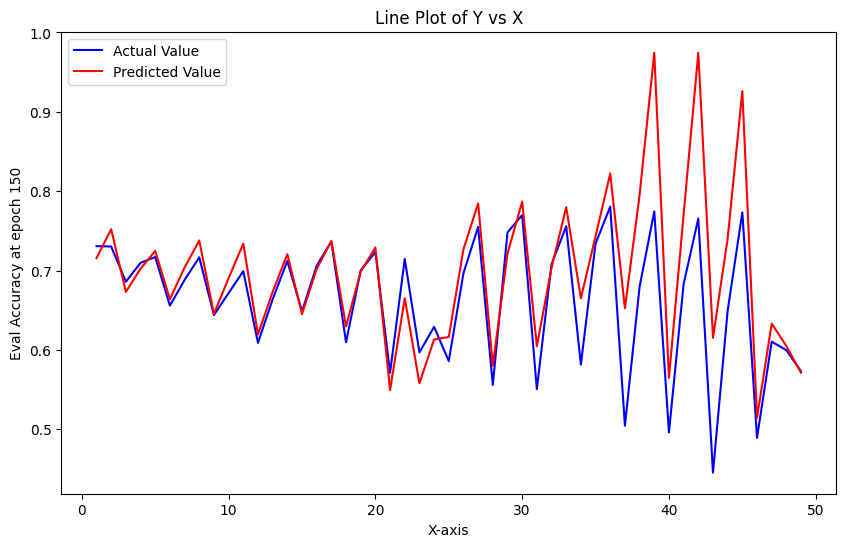

In [196]:
x = [i+1 for i in range(len(test_np_data_x))]
y1 = test_np_data_y
y2 = prediction

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Actual Value', color='blue')
plt.plot(x, y2, label='Predicted Value', color='red')
plt.title('Line Plot of Y vs X')
plt.xlabel('X-axis')
plt.ylabel('Eval Accuracy at epoch 150')
plt.legend()
plt.show()

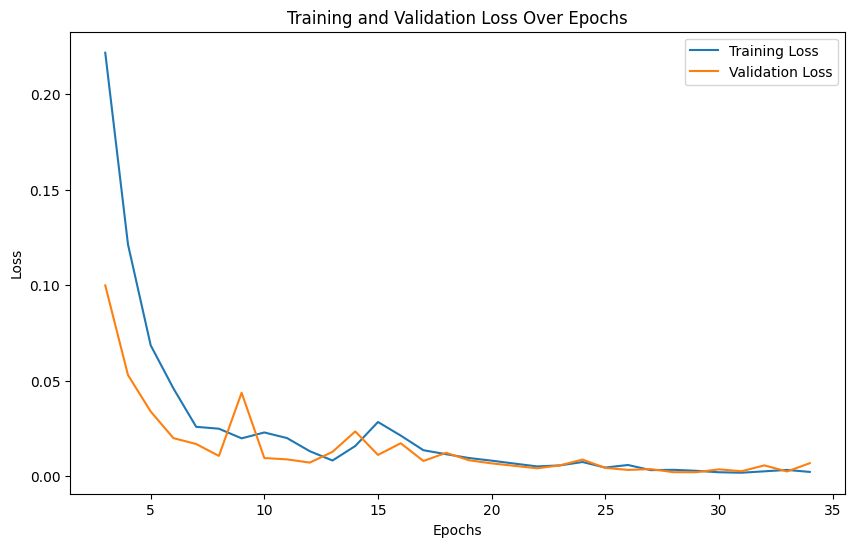

In [199]:
plt.figure(figsize=(10, 6))

x = [i+3 for i in range(len(history2.history['loss'][3:]))]

# Plot training loss
plt.plot(x, history2.history['loss'][3:], label='Training Loss')

# Plot validation loss
plt.plot(x, history2.history['val_loss'][3:], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Showing the plot
plt.show()

### E=20, M=150

In [206]:
# define parameters
num_sequences = 10
time_steps = 20
features = 7
batch_Size = 8

# Get data
train_np_data_x = get_np_data(train_data, time_steps)
val_np_data_x = get_np_data(val_data, time_steps)
test_np_data_x = get_np_data(test_data, time_steps)
train_np_data_y = get_np_y_data(train_data)
val_np_data_y = get_np_y_data(val_data)
test_np_data_y = get_np_y_data(test_data)

# define model
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 20, 16)            1536      
                                                                 
 lstm_49 (LSTM)              (None, 32)                6272      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


In [207]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [208]:
checkpoint = ModelCheckpoint(
    filepath='./ckpt/e20/model_epoch_{epoch:02d}.h5',  # Path to save the model file with epoch number
    monitor='val_loss',  
    save_best_only=False,  
    mode='auto',  
    verbose=1,
    save_freq='epoch'
)

In [209]:
history3 = model.fit(train_np_data_x, train_np_data_y, epochs=35, batch_size=batch_Size, validation_data=(val_np_data_x, val_np_data_y) ,callbacks=[checkpoint])

Epoch 1/35
13/13 [==============================] - ETA: 0s - loss: 41.1489
Epoch 1: saving model to ./ckpt/e20/model_epoch_01.h5
13/13 [==============================] - 7s 147ms/step - loss: 41.1489 - val_loss: 13.9189
Epoch 2/35
13/13 [==============================] - ETA: 0s - loss: 13.0018
Epoch 2: saving model to ./ckpt/e20/model_epoch_02.h5
13/13 [==============================] - 1s 95ms/step - loss: 13.0018 - val_loss: 5.0570
Epoch 3/35
13/13 [==============================] - ETA: 0s - loss: 3.7242
Epoch 3: saving model to ./ckpt/e20/model_epoch_03.h5
13/13 [==============================] - 1s 111ms/step - loss: 3.7242 - val_loss: 1.9554
Epoch 4/35
13/13 [==============================] - ETA: 0s - loss: 0.9670
Epoch 4: saving model to ./ckpt/e20/model_epoch_04.h5
13/13 [==============================] - 1s 97ms/step - loss: 0.9670 - val_loss: 0.6303
Epoch 5/35
13/13 [==============================] - ETA: 0s - loss: 0.6821
Epoch 5: saving model to ./ckpt/e20/model_epoch_05

In [211]:
prediction = model.predict(test_np_data_x)

2/2 [==============================] - 0s 13ms/step


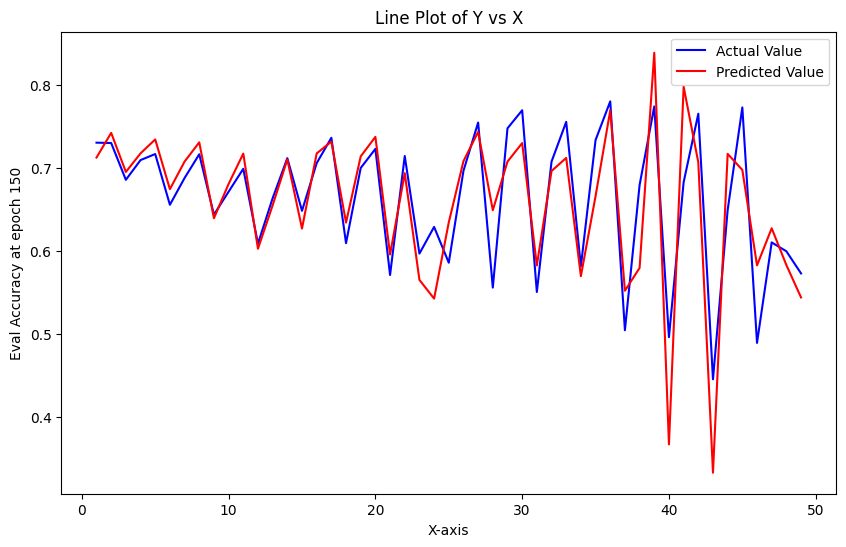

In [212]:
x = [i+1 for i in range(len(test_np_data_x))]
y1 = test_np_data_y
y2 = prediction

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Actual Value', color='blue')
plt.plot(x, y2, label='Predicted Value', color='red')
plt.title('Line Plot of Y vs X')
plt.xlabel('X-axis')
plt.ylabel('Eval Accuracy at epoch 150')
plt.legend()
plt.show()

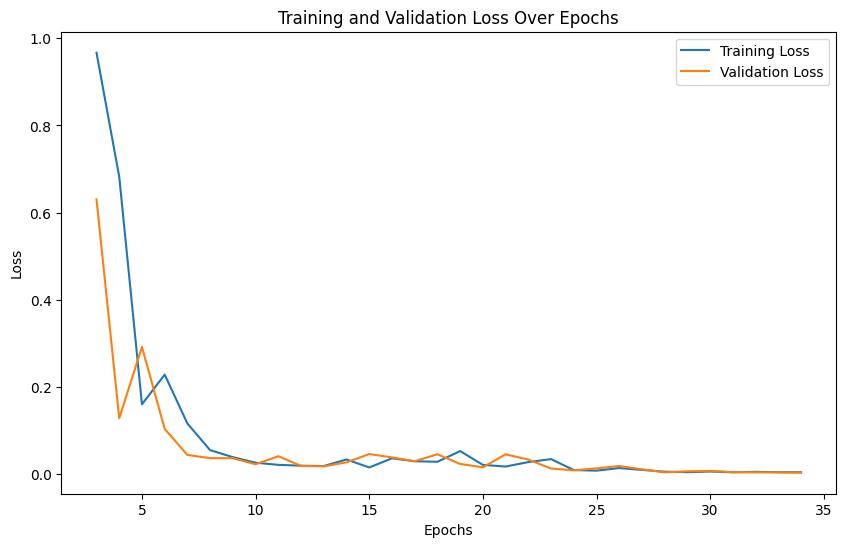

In [213]:
plt.figure(figsize=(10, 6))

x = [i+3 for i in range(len(history3.history['loss'][3:]))]

# Plot training loss
plt.plot(x, history3.history['loss'][3:], label='Training Loss')

# Plot validation loss
plt.plot(x, history3.history['val_loss'][3:], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Showing the plot
plt.show()

### E=30, M=150

In [242]:
# define parameters
num_sequences = 10
time_steps = 30
features = 7
batch_Size = 8

# Get data
train_np_data_x = get_np_data(train_data, time_steps)
val_np_data_x = get_np_data(val_data, time_steps)
test_np_data_x = get_np_data(test_data, time_steps)
train_np_data_y = get_np_y_data(train_data)
val_np_data_y = get_np_y_data(val_data)
test_np_data_y = get_np_y_data(test_data)

# define model
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 30, 16)            1536      
                                                                 
 lstm_63 (LSTM)              (None, 32)                6272      
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


In [243]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

checkpoint = ModelCheckpoint(
    filepath='./ckpt/e30/model_epoch_{epoch:02d}.h5',  # Path to save the model file with epoch number
    monitor='val_loss',  
    save_best_only=False,  
    mode='auto',  
    verbose=1,
    save_freq='epoch'
)

In [244]:
history4 = model.fit(train_np_data_x, train_np_data_y, epochs=35, batch_size=batch_Size, validation_data=(val_np_data_x, val_np_data_y) ,callbacks=[checkpoint])

Epoch 1/35
13/13 [==============================] - ETA: 0s - loss: 58.3852
Epoch 1: saving model to ./ckpt/e30/model_epoch_01.h5
13/13 [==============================] - 10s 224ms/step - loss: 58.3852 - val_loss: 19.0210
Epoch 2/35
13/13 [==============================] - ETA: 0s - loss: 13.5574
Epoch 2: saving model to ./ckpt/e30/model_epoch_02.h5
13/13 [==============================] - 2s 166ms/step - loss: 13.5574 - val_loss: 0.7910
Epoch 3/35
13/13 [==============================] - ETA: 0s - loss: 0.4033
Epoch 3: saving model to ./ckpt/e30/model_epoch_03.h5
13/13 [==============================] - 2s 194ms/step - loss: 0.4033 - val_loss: 0.2033
Epoch 4/35
13/13 [==============================] - ETA: 0s - loss: 0.0955
Epoch 4: saving model to ./ckpt/e30/model_epoch_04.h5
13/13 [==============================] - 2s 186ms/step - loss: 0.0955 - val_loss: 0.0341
Epoch 5/35
13/13 [==============================] - ETA: 0s - loss: 0.0459
Epoch 5: saving model to ./ckpt/e30/model_epoch

In [245]:
prediction = model.predict(test_np_data_x)

2/2 [==============================] - 0s 17ms/step


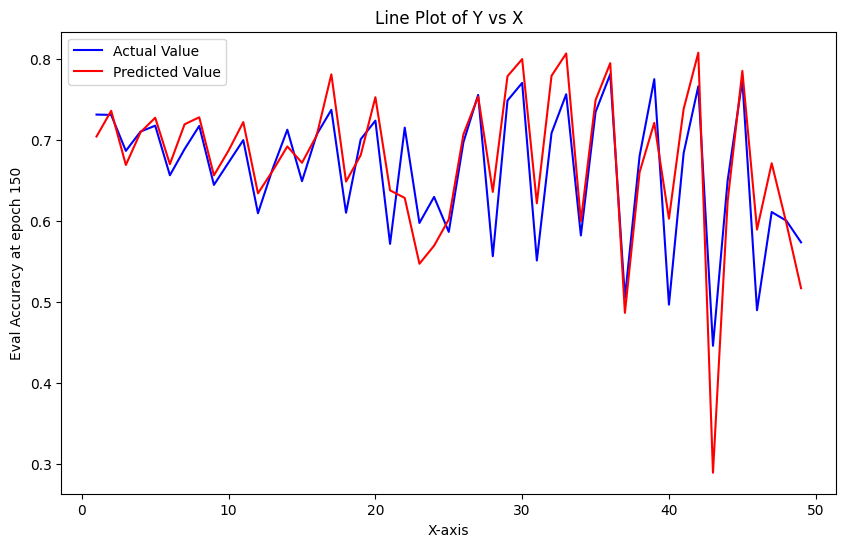

In [246]:
x = [i+1 for i in range(len(test_np_data_x))]
y1 = test_np_data_y
y2 = prediction

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Actual Value', color='blue')
plt.plot(x, y2, label='Predicted Value', color='red')
plt.title('Line Plot of Y vs X')
plt.xlabel('X-axis')
plt.ylabel('Eval Accuracy at epoch 150')
plt.legend()
plt.show()

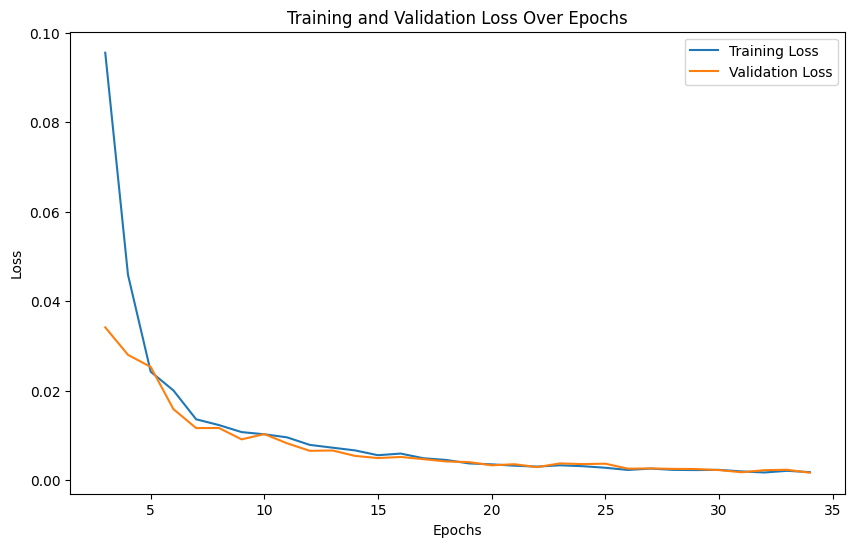

In [247]:
plt.figure(figsize=(10, 6))

x = [i+3 for i in range(len(history4.history['loss'][3:]))]

# Plot training loss
plt.plot(x, history4.history['loss'][3:], label='Training Loss')

# Plot validation loss
plt.plot(x, history4.history['val_loss'][3:], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Showing the plot
plt.show()

### E=60, M=150

In [257]:
# define parameters
num_sequences = 10
time_steps = 60
features = 7
batch_Size = 8

# Get data
train_np_data_x = get_np_data(train_data, time_steps)
val_np_data_x = get_np_data(val_data, time_steps)
test_np_data_x = get_np_data(test_data, time_steps)
train_np_data_y = get_np_y_data(train_data)
val_np_data_y = get_np_y_data(val_data)
test_np_data_y = get_np_y_data(test_data)

# define model
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(time_steps, features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 60, 16)            1536      
                                                                 
 lstm_69 (LSTM)              (None, 32)                6272      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


In [258]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

checkpoint = ModelCheckpoint(
    filepath='./ckpt/e60/model_epoch_{epoch:02d}.h5',  # Path to save the model file with epoch number
    monitor='val_loss',  
    save_best_only=False,  
    mode='auto',  
    verbose=1,
    save_freq='epoch'
)

In [259]:
history5 = model.fit(train_np_data_x, train_np_data_y, epochs=50, batch_size=batch_Size, validation_data=(val_np_data_x, val_np_data_y) ,callbacks=[checkpoint])

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 8.0186
Epoch 1: saving model to ./ckpt/e60/model_epoch_01.h5
13/13 [==============================] - 11s 373ms/step - loss: 8.0186 - val_loss: 5.1734
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 9.6862
Epoch 2: saving model to ./ckpt/e60/model_epoch_02.h5
13/13 [==============================] - 4s 285ms/step - loss: 9.6862 - val_loss: 6.3639
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 3.5736
Epoch 3: saving model to ./ckpt/e60/model_epoch_03.h5
13/13 [==============================] - 4s 283ms/step - loss: 3.5736 - val_loss: 1.3713
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.6591
Epoch 4: saving model to ./ckpt/e60/model_epoch_04.h5
13/13 [==============================] - 5s 361ms/step - loss: 0.6591 - val_loss: 0.2008
Epoch 5/50
13/13 [==============================] - ETA: 0s - loss: 0.2287
Epoch 5: saving model to ./ckpt/e60/model_epoch_05.h

In [260]:
prediction = model.predict(test_np_data_x)

2/2 [==============================] - 1s 47ms/step


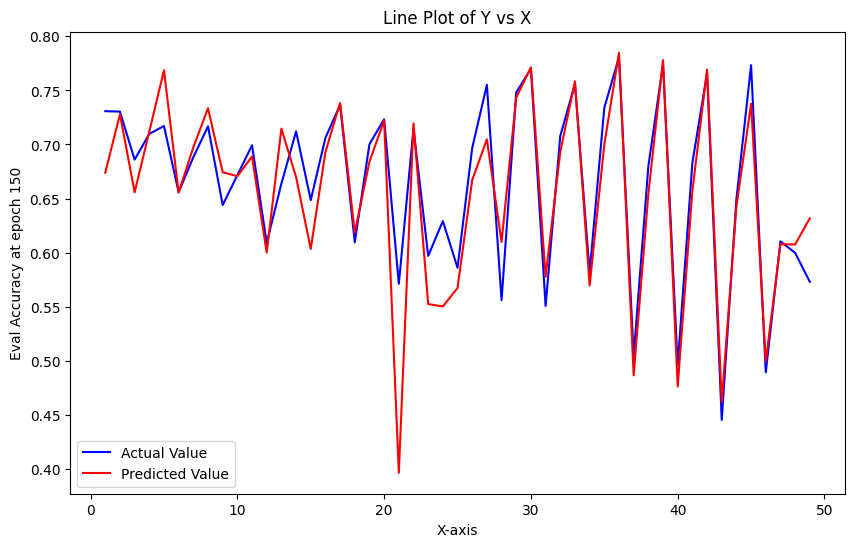

In [261]:
x = [i+1 for i in range(len(test_np_data_x))]
y1 = test_np_data_y
y2 = prediction

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Actual Value', color='blue')
plt.plot(x, y2, label='Predicted Value', color='red')
plt.title('Line Plot of Y vs X')
plt.xlabel('X-axis')
plt.ylabel('Eval Accuracy at epoch 150')
plt.legend()
plt.show()

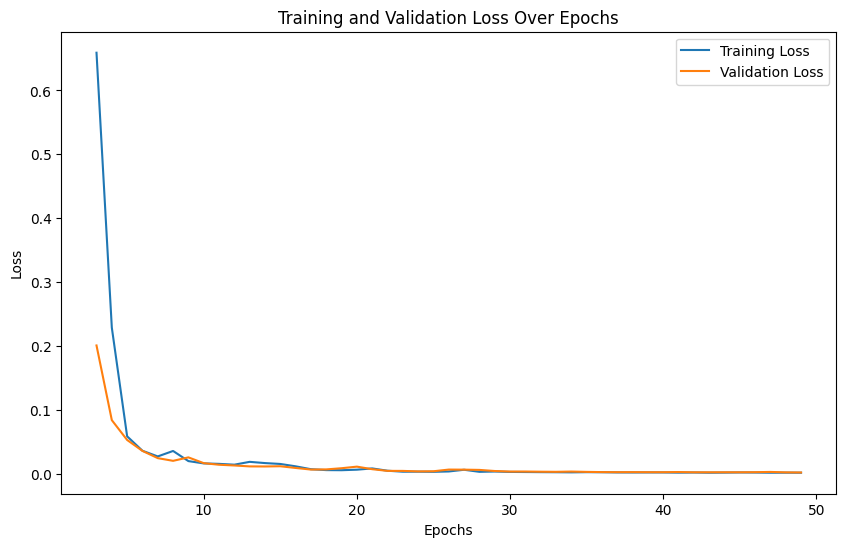

In [262]:
plt.figure(figsize=(10, 6))

x = [i+3 for i in range(len(history5.history['loss'][3:]))]

# Plot training loss
plt.plot(x, history5.history['loss'][3:], label='Training Loss')

# Plot validation loss
plt.plot(x, history5.history['val_loss'][3:], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Showing the plot
plt.show()